# Pnumonia Classification

### Victor Manuel Fonte Chavez

En esta tarea tomaremos datos de rayos x de casos de pneumonia y casos sin esta y crearemos utilizando transferencia de conocimiento un modelo convolucional para clasificar en casos con dicha enfermedad y sin esta

In [ ]:
import pandas as pd
import numpy as np 

import os, shutil

from skimage import color
import skimage.io as io 
import cv2

from sklearn.metrics import confusion_matrix, roc_auc_score

import tensorflow as tf
from tensorflow import keras

from keras.applications import ResNet50 
from keras.applications.resnet import preprocess_input
# from keras.applications import EfficientNetB3
# from keras.applications.efficientnet import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, GlobalAveragePooling2D, BatchNormalization, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, Nadam, Adam
from sklearn.utils import class_weight

import matplotlib.pyplot as plt

# Preprocesado de los datos 

Comenzaremos creando la estructura de directorios para usarlos mas adelante en generadores

In [2]:
try:
    base_dir = '/kaggle/working'

    train_dir = os.path.join(base_dir, 'train')
    os.mkdir(train_dir)
    os.stat(train_dir)

    val_dir = os.path.join(base_dir, 'val')
    os.mkdir(val_dir)
    os.stat(val_dir)

    test_dir = os.path.join(base_dir, 'test')
    os.mkdir(test_dir)
    os.stat(test_dir)

    #pneumonia cases
    train_pneumonia_dir = os.path.join(train_dir, 'pneumonia')
    os.mkdir(train_pneumonia_dir)
    os.stat(train_pneumonia_dir)

    val_pneumonia_dir = os.path.join(val_dir, 'pneumonia')
    os.mkdir(val_pneumonia_dir)
    os.stat(val_pneumonia_dir)

    test_pneumonia_dir = os.path.join(test_dir, 'pneumonia')
    os.mkdir(test_pneumonia_dir)
    os.stat(test_pneumonia_dir)

    #not pneumonia cases
    train_not_pneumonia_dir = os.path.join(train_dir, 'not_pneumonia')
    os.mkdir(train_not_pneumonia_dir)
    os.stat(train_not_pneumonia_dir)

    val_not_pneumonia_dir = os.path.join(val_dir, 'not_pneumonia')
    os.mkdir(val_not_pneumonia_dir)
    os.stat(val_not_pneumonia_dir)

    test_not_pneumonia_dir = os.path.join(test_dir, 'not_pneumonia')
    os.mkdir(test_not_pneumonia_dir)
    os.stat(test_not_pneumonia_dir)
    
    print('Estructura de directorios completa')
    
except: 
    print('Estructura de directorios incompleta')

Estructura de directorios completa


Esta tarea fue realizada usando una gpu de kaggle.com, por lo tanto en esta celda lo que se hace es transferir los datos de la seccion de input a la seccion de trabajo, en donde se crearon los directorios.

In [3]:
chest_train_dir = '../input/chest-xray-pneumonia/chest_xray/train'
chest_val_dir = '../input/chest-xray-pneumonia/chest_xray/val'
chest_test_dir = '../input/chest-xray-pneumonia/chest_xray/test'

def move_chest(chest_dir, to):
    for d in os.listdir(chest_dir):
        for p in os.listdir(chest_dir +'/'+d):
            if d == 'NORMAL':
                shutil.copy(chest_dir +'/'+d+'/'+p, '/kaggle/working/'+to+'/not_pneumonia/'+p)
            else:
                shutil.copy(chest_dir +'/'+d+'/'+p, '/kaggle/working/'+to+'/pneumonia/'+p)
                
move_chest(chest_train_dir, 'train')
move_chest(chest_val_dir, 'val')
move_chest(chest_test_dir, 'test')

In [4]:
print("Cantida de fotos importadas")
print("pneumonia")
print(len(os.listdir(train_pneumonia_dir)))
print(len(os.listdir(test_pneumonia_dir)))
print(len(os.listdir(val_pneumonia_dir)))
print("not pneumonua")
print(len(os.listdir(train_not_pneumonia_dir)))
print(len(os.listdir(test_not_pneumonia_dir)))
print(len(os.listdir(val_not_pneumonia_dir)))

print("\nCantidad de fotos que debe haber")
print("pneumonia")
print(len(os.listdir(os.path.join(chest_train_dir, 'PNEUMONIA'))))
print(len(os.listdir(os.path.join(chest_test_dir, 'PNEUMONIA'))))
print(len(os.listdir(os.path.join(chest_val_dir, 'PNEUMONIA'))))
print("not pneumonua")
print(len(os.listdir(os.path.join(chest_train_dir, 'NORMAL'))))
print(len(os.listdir(os.path.join(chest_test_dir, 'NORMAL'))))
print(len(os.listdir(os.path.join(chest_val_dir, 'NORMAL'))))

Cantida de fotos importadas
pneumonia
3875
390
8
not pneumonua
1341
234
8

Cantidad de fotos que debe haber
pneumonia
3875
390
8
not pneumonua
1341
234
8


Dado que los conjuntos de validacio y prueba relacionados a su respectiva clase estan desvalanceados y eso conllevaria a sesgos en las metricas, ademas de la poca cantidad de datos en el conjunto de validacion, se distribuiran los datos tal que queden en iguales proporciones en cada clase

In [5]:
test_lisdir_neu = os.listdir(test_pneumonia_dir)
for i in range(len(test_lisdir_neu)):
    if i == 140: break
    shutil.move(test_pneumonia_dir+'/'+ test_lisdir_neu[i], val_pneumonia_dir+'/'+ test_lisdir_neu[i])

train_lisdir_neu = os.listdir(train_pneumonia_dir)
for i in range(len(train_lisdir_neu)):
    if i == 52: break
    shutil.move(train_pneumonia_dir+'/'+ train_lisdir_neu[i], val_pneumonia_dir+'/'+ train_lisdir_neu[i])
    
train_lisdir_noneu = os.listdir(train_not_pneumonia_dir)
for i in range(len(train_lisdir_noneu)):
    if i == 16: break
    shutil.move(train_not_pneumonia_dir+'/'+ train_lisdir_noneu[i], test_not_pneumonia_dir+'/'+ train_lisdir_noneu[i])

train_lisdir_noneu = os.listdir(train_not_pneumonia_dir)
for i in range(len(train_lisdir_noneu)):
    if i == 192: break
    shutil.move(train_not_pneumonia_dir+'/'+ train_lisdir_noneu[i], val_not_pneumonia_dir+'/'+ train_lisdir_noneu[i])

In [6]:
print("Cantida de fotos importadas")
print("pneumonia")
print(len(os.listdir(train_pneumonia_dir)))
print(len(os.listdir(test_pneumonia_dir)))
print(len(os.listdir(val_pneumonia_dir)))
print("not pneumonua")
print(len(os.listdir(train_not_pneumonia_dir)))
print(len(os.listdir(test_not_pneumonia_dir)))
print(len(os.listdir(val_not_pneumonia_dir)))

Cantida de fotos importadas
pneumonia
3823
250
200
not pneumonua
1133
250
200


En esta seccion se reduce el tamaño de cada foto de (1024, 1024) a (256, 256)

In [7]:
def resize(dir):
    for p in os.listdir(dir):
        img = plt.imread(dir+'/'+p)
        img = cv2.resize(img, (256, 256))
        io.imsave(dir+'/'+p, img)

resize(train_pneumonia_dir)
print("train_pneumonia_dir")
resize(val_pneumonia_dir)
print("val_pneumonia_dir")
resize(test_pneumonia_dir)
print("test_pneumonia_dir")
resize(train_not_pneumonia_dir)
print("train_not_pneumonia_dir")
resize(test_not_pneumonia_dir)
print("test_not_pneumonia_dir")
resize(val_not_pneumonia_dir)
print("val_not_pneumonia_dir")

train_pneumonia_dir
val_pneumonia_dir
test_pneumonia_dir
train_not_pneumonia_dir
test_not_pneumonia_dir
val_not_pneumonia_dir


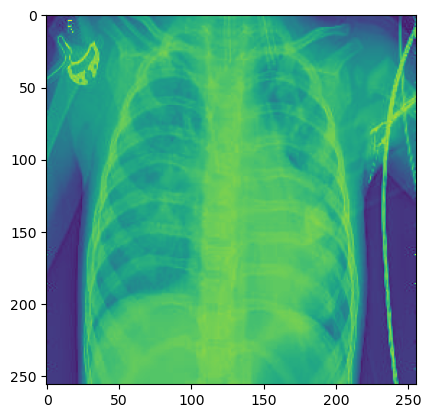

In [8]:
id = os.listdir(train_pneumonia_dir)[0]
x = plt.imread(os.path.join(train_pneumonia_dir, id))
plt.imshow(x)

# Entrenamiento de los modelos

Comenzaremos creando generadores y dando las caracteristicas de estos. En el conjunto de entrenamiento se define el proceso de aumentacion de dato y en los demas se dejan como estan. 

In [31]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   zoom_range=0.1, 
                                   height_shift_range=0.05, 
                                   width_shift_range=0.05,
                                   rotation_range=5)
val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_dir = "/kaggle/working/train"
val_dir = "/kaggle/working/val"
test_dir = "/kaggle/working/test"

train_generator = train_datagen.flow_from_directory(
                        train_dir,              
                        target_size= (256, 256), 
                        batch_size = 32,   
                        shuffle    = True,
                        class_mode = 'categorical')    

val_generator = val_test_datagen.flow_from_directory(
                        val_dir,
                        target_size=(256, 256),
                        batch_size=32,
                        shuffle=False,
                        class_mode='categorical')

test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=(256, 256),
        batch_size=32,
        shuffle=False,
        class_mode='categorical')

Found 4956 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


Para la creacion de los modelos se utiliza la red preentrenada `ResNet50` y se comienza entrenando la etapa de clasificacion con la capa convolucional conjelada

In [32]:
conv_base = ResNet50(include_top=False, 
                       weights='imagenet', 
                       input_shape=(256, 256, 3))

conv_base.trainable = False

# efnet = EfficientNetB3(include_top=False, 
#                        weights='imagenet', 
#                        input_shape=(250, 250, 3))
# efnet.trainable = False

Se crea la arquitectura de la red con una capa densa con activacion `Relu` y una capa Dropout con un porciento de eliminacion de neuronas de 0.2 

In [49]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())

model.add(Dense(units=256))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

In [50]:
model.compile(loss='categorical_crossentropy',
                optimizer=RMSprop(learning_rate=1e-5),
                metrics=['acc'])

In [51]:
history = model.fit(train_generator,
                    steps_per_epoch = 100,
                    epochs=20,
                    validation_data=val_generator,
                    #validation_steps=30,
                    verbose = 1)

Epoch 1/20
100/100 [==============================] - 51s 484ms/step - loss: 0.2432 - acc: 0.9321 - val_loss: 0.1239 - val_acc: 0.9425
Epoch 2/20
100/100 [==============================] - 48s 480ms/step - loss: 0.1021 - acc: 0.9638 - val_loss: 0.0365 - val_acc: 0.9850
Epoch 3/20
100/100 [==============================] - 48s 477ms/step - loss: 0.1045 - acc: 0.9684 - val_loss: 0.0273 - val_acc: 0.9925
Epoch 4/20
100/100 [==============================] - 48s 484ms/step - loss: 0.0690 - acc: 0.9762 - val_loss: 0.0442 - val_acc: 0.9825
Epoch 5/20
100/100 [==============================] - 48s 477ms/step - loss: 0.0662 - acc: 0.9803 - val_loss: 0.0210 - val_acc: 0.9950
Epoch 6/20
100/100 [==============================] - 49s 491ms/step - loss: 0.0703 - acc: 0.9775 - val_loss: 0.0196 - val_acc: 0.9925
Epoch 7/20
100/100 [==============================] - 47s 472ms/step - loss: 0.0444 - acc: 0.9859 - val_loss: 0.0248 - val_acc: 0.9925
Epoch 8/20
100/100 [==============================] - 4

Para visualizar mejor los datos aplicamos un filtro recursivo para apreciar la tendencia, ya que las salidas en este caso son un poco ruidosas. El filtro seria:

$$\hat s = \alpha\hat s_{i - 1} + (1 - \alpha)\hat s_i$$

o sea una combinacion lineal convexa de los puntos

In [54]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

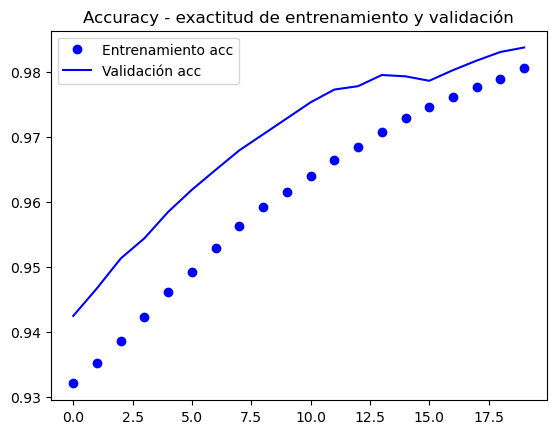

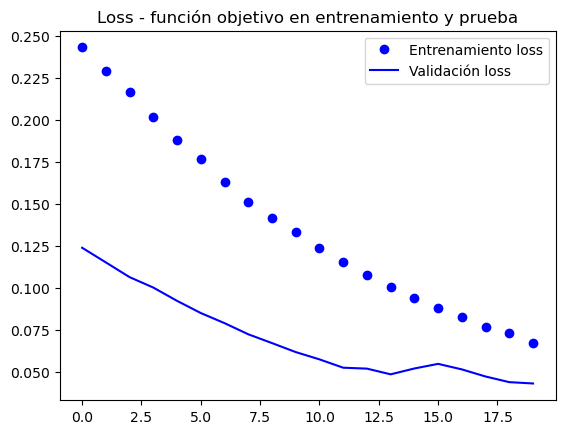

In [55]:
acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
alpha = 0.9

plt.plot(epochs, smooth_curve(acc,     alpha), 'bo', label='Entrenamiento acc')
plt.plot(epochs, smooth_curve(val_acc, alpha), 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss,    alpha), 'bo', label='Entrenamiento loss')
plt.plot(epochs, smooth_curve(val_loss,alpha), 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

Se puede observar que no existe sobreajuste en el modelo y se espera que tenga una buena presicion

In [56]:
y_pred = model.predict(test_generator, verbose=1)
y_true = test_generator.classes

conf_mat = confusion_matrix(y_true, np.argmax(y_pred, axis=1))
print('Confusion matrix:')
print(conf_mat)

accuracy = (conf_mat[0,0]+conf_mat[1,1])/sum(sum(conf_mat))
print('Accuracy:', accuracy)

specificity = conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
print('Specificity:', specificity)

recall = conf_mat[1,1]/(conf_mat[1,0]+conf_mat[1,1])
print('Sensitivity:', recall)

precision = conf_mat[1,1]/(conf_mat[0,1]+conf_mat[1,1])
print('Precision:', precision)

AUC = roc_auc_score(y_true, y_pred[:,1])
print('AUC-ROC:', AUC)


16/16 [==============================] - 2s 90ms/step
Confusion matrix:
[[211  39]
 [  4 246]]
Accuracy: 0.914
Specificity: 0.844
Sensitivity: 0.984
Precision: 0.8631578947368421
AUC-ROC: 0.982184


In [57]:
model.save('/kaggle/working/models/model1')

# Fine Tuning

Comenzaremos descongelando las 15 ultimas capas del modelo para entrenarlas

In [59]:
conv_base.trainable = False

for layer in conv_base.layers[-15:]:
    layer.trainable = True

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=1e-5),
              metrics=['acc'])

In [60]:
history = model.fit(train_generator,
      steps_per_epoch=100,
      epochs=10,
      validation_data=val_generator)

Epoch 1/10
100/100 [==============================] - 51s 479ms/step - loss: 0.0427 - acc: 0.9909 - val_loss: 0.0191 - val_acc: 0.9975
Epoch 2/10
100/100 [==============================] - 47s 467ms/step - loss: 0.0343 - acc: 0.9906 - val_loss: 0.0132 - val_acc: 0.9950
Epoch 3/10
100/100 [==============================] - 47s 471ms/step - loss: 0.0303 - acc: 0.9925 - val_loss: 0.0085 - val_acc: 0.9975
Epoch 4/10
100/100 [==============================] - 48s 481ms/step - loss: 0.0196 - acc: 0.9953 - val_loss: 0.0101 - val_acc: 0.9975
Epoch 5/10
100/100 [==============================] - 47s 466ms/step - loss: 0.0206 - acc: 0.9944 - val_loss: 0.0089 - val_acc: 0.9950
Epoch 6/10
100/100 [==============================] - 48s 482ms/step - loss: 0.0273 - acc: 0.9922 - val_loss: 0.0077 - val_acc: 0.9975
Epoch 7/10
100/100 [==============================] - 46s 464ms/step - loss: 0.0199 - acc: 0.9947 - val_loss: 0.0086 - val_acc: 0.9975
Epoch 8/10
100/100 [==============================] - 4

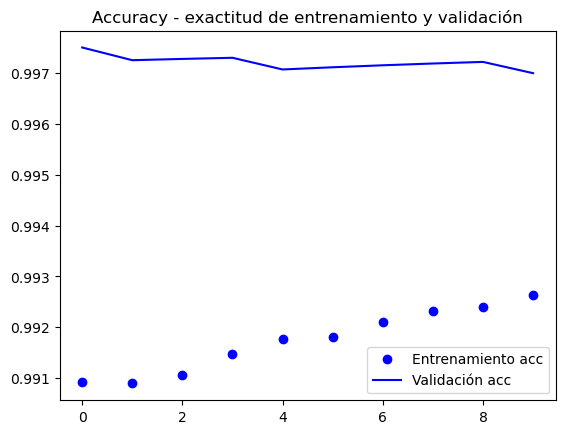

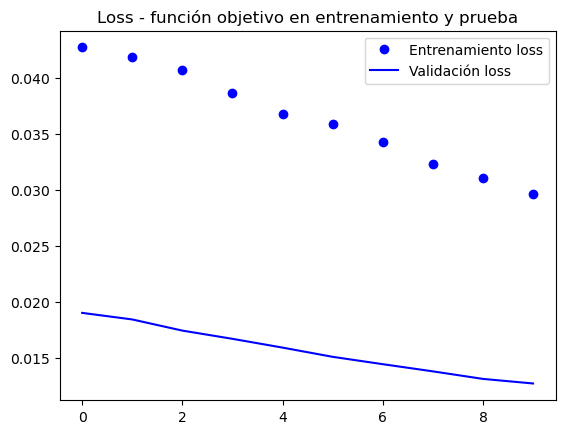

In [62]:
acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
alpha = 0.9

plt.plot(epochs, smooth_curve(acc,     alpha), 'bo', label='Entrenamiento acc')
plt.plot(epochs, smooth_curve(val_acc, alpha), 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss,    alpha), 'bo', label='Entrenamiento loss')
plt.plot(epochs, smooth_curve(val_loss,alpha), 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

In [63]:
y_pred = model.predict(test_generator, verbose=1)
y_true = test_generator.classes

conf_mat = confusion_matrix(y_true, np.argmax(y_pred, axis=1))
print('Confusion matrix:')
print(conf_mat)

accuracy = (conf_mat[0,0]+conf_mat[1,1])/sum(sum(conf_mat))
print('Accuracy:', accuracy)

specificity = conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
print('Specificity:', specificity)

recall = conf_mat[1,1]/(conf_mat[1,0]+conf_mat[1,1])
print('Sensitivity:', recall)

precision = conf_mat[1,1]/(conf_mat[0,1]+conf_mat[1,1])
print('Precision:', precision)

AUC = roc_auc_score(y_true, y_pred[:,1])
print('AUC-ROC:', AUC)

16/16 [==============================] - 2s 92ms/step
Confusion matrix:
[[161  89]
 [  2 248]]
Accuracy: 0.818
Specificity: 0.644
Sensitivity: 0.992
Precision: 0.7359050445103857
AUC-ROC: 0.94692


In [64]:
model.save('/kaggle/working/models/model2')

# Full Tuning

Ahora entrenaremos todo el modelo, capa convolucional y capa de densa

In [67]:
conv_base.trainable = True

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=1e-5),
              metrics=['acc'])

history = model.fit(train_generator,
      steps_per_epoch=100,
      epochs=20,
      validation_data=val_generator)

Epoch 1/20
100/100 [==============================] - 86s 545ms/step - loss: 0.1027 - acc: 0.9768 - val_loss: 0.0365 - val_acc: 0.9850
Epoch 2/20
100/100 [==============================] - 52s 520ms/step - loss: 0.0738 - acc: 0.9809 - val_loss: 0.1307 - val_acc: 0.9650
Epoch 3/20
100/100 [==============================] - 53s 524ms/step - loss: 0.0421 - acc: 0.9878 - val_loss: 0.0565 - val_acc: 0.9850
Epoch 4/20
100/100 [==============================] - 53s 524ms/step - loss: 0.0398 - acc: 0.9906 - val_loss: 0.0658 - val_acc: 0.9800
Epoch 5/20
100/100 [==============================] - 52s 522ms/step - loss: 0.0355 - acc: 0.9897 - val_loss: 0.0634 - val_acc: 0.9900
Epoch 6/20
100/100 [==============================] - 53s 526ms/step - loss: 0.0218 - acc: 0.9919 - val_loss: 0.0342 - val_acc: 0.9925
Epoch 7/20
100/100 [==============================] - 52s 520ms/step - loss: 0.0331 - acc: 0.9909 - val_loss: 0.0255 - val_acc: 0.9925
Epoch 8/20
100/100 [==============================] - 5

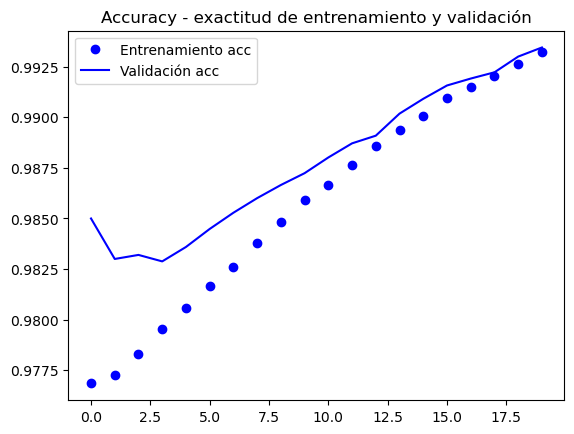

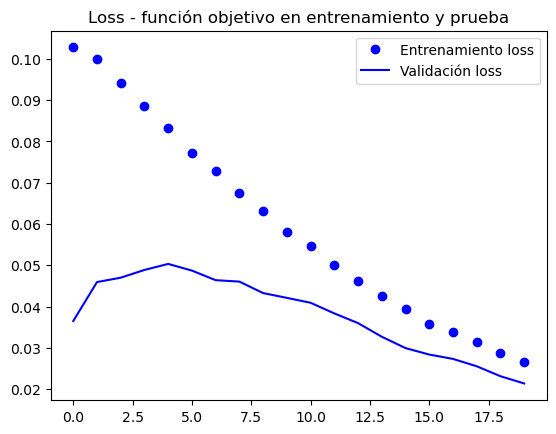

In [68]:
acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
alpha = 0.9

plt.plot(epochs, smooth_curve(acc,     alpha), 'bo', label='Entrenamiento acc')
plt.plot(epochs, smooth_curve(val_acc, alpha), 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss,    alpha), 'bo', label='Entrenamiento loss')
plt.plot(epochs, smooth_curve(val_loss,alpha), 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

In [69]:
y_pred = model.predict(test_generator, verbose=1)
y_true = test_generator.classes

conf_mat = confusion_matrix(y_true, np.argmax(y_pred, axis=1))
print('Confusion matrix:')
print(conf_mat)

accuracy = (conf_mat[0,0]+conf_mat[1,1])/sum(sum(conf_mat))
print('Accuracy:', accuracy)

specificity = conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
print('Specificity:', specificity)

recall = conf_mat[1,1]/(conf_mat[1,0]+conf_mat[1,1])
print('Sensitivity:', recall)

precision = conf_mat[1,1]/(conf_mat[0,1]+conf_mat[1,1])
print('Precision:', precision)

AUC = roc_auc_score(y_true, y_pred[:,1])
print('AUC-ROC:', AUC)

16/16 [==============================] - 2s 97ms/step
Confusion matrix:
[[189  61]
 [  3 247]]
Accuracy: 0.872
Specificity: 0.756
Sensitivity: 0.988
Precision: 0.801948051948052
AUC-ROC: 0.942048


In [70]:
model.save('/kaggle/working/models/model3')

Por ultimo se crea un zip con todo lo del directorio de trabajo para poder descargarlo 

In [71]:
shutil.make_archive('/kaggle/working/models', 'zip', '/kaggle/working')

'/kaggle/working/models.zip'